In [1]:
import sys

sys.path.append('/project/3022057.01/IFA/utils')

import os
import json
from preprocessing_PCN import continuous_confounders, categorical_confounders
from pyriemann.estimation import Covariances
import numpy as np
from sklearn.model_selection import StratifiedKFold
import subprocess
import pickle
from analysis import evaluate_IFA_results

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
import pandas as pd

# Load the DataFrame from the pickle file
loaded_df = pd.read_pickle('/project/3022057.01/PNC/phenotype_parcellated_data.pkl')


In [3]:
settings = {
    "phenotype": ["OCD025","M_18+"],
    "percentile": 0.0,
    "outputfolder": "Run_9",
    "n_folds": 5,
    "random_state": 42,
    "n_filters_per_group": 2,
    "nPCA": 30,
    "Tangent_Class": True,
    "metric": "logeuclid",
    "a_label": 1,
    "b_label": 0,
    "self_whiten": False,
    "deconfound": False
}

# Ensure the output folder exists
outputfolder = settings["outputfolder"]
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

In [4]:
# Define the path for the settings file
settings_filepath = os.path.join(outputfolder, "settings.json")

# Save the settings to a JSON file
with open(settings_filepath, "w") as f:
    json.dump(settings, f, indent=4)

phenotype = settings["phenotype"]
percentile = settings["percentile"]
n_folds = settings["n_folds"]
random_state = settings["random_state"]
n_filters_per_group = settings["n_filters_per_group"]
nPCA = settings["nPCA"]
Tangent_Class = settings["Tangent_Class"]
metric = settings["metric"]
a_label = int(settings["a_label"])
b_label = int(settings["b_label"])
self_whiten = settings["self_whiten"]
deconfound = settings["deconfound"]

In [26]:
# from collections import defaultdict
# import random
# from tangent import tangent_classification

# # Define the allowed values
# allowed_values = {0, 1, 9}  # Use np.nan for 'NA' in a pandas DataFrame
# # Find columns with only the allowed values

# # Get the keys as a list and shuffle them
# keys = list(loaded_df.keys())
# random.shuffle(keys)
# # Malekeys =["MED806", "MED242", "MAN025", "MAN026", "SOC008", "OCD011", "SOC002", "AGR013", "SOC008", "MED074","CDD003","MAN009", "ADD017", "OCD025","MED074"]
# # keys = ["MED805", "CDD015", "MED740", "MED743",  "SEP521", "MED805", "MED806", "OCD025", "ADD034A", "CDD015", "MED242", "CDD017", "MED125", "OCD024", "GAD011A", "OCD010", "MED241", "OCD016", "MED125", "PSY154", "MED082"]
# #  After Deconfounding: MED806 MED242

# # Iterate through the keys in the new random order
# for key in keys:    
#     if key != "parcellated_data":
#         unique_values = set(loaded_df[key].dropna().unique())  # Drop NaNs for comparison
#         if unique_values.issubset(allowed_values):  # Compare without including np.nan
#             a = loaded_df[(loaded_df["INT_TYPE"] == "AP") & (loaded_df["Sex"] == "M") & (loaded_df[keys] == 1)]  # Controls: No ADD
#             b = loaded_df[(loaded_df["INT_TYPE"] == "AP") & (loaded_df["Sex"] == "M") & (loaded_df[keys] == 0)]  # Cases: ADD
#             # Equalize sample sizes between groups
#             min_size = min(len(a), len(b))
#             if min_size < 10 or key == 'ADD011':
#                 continue

#             print(f"--------------{key}--------------")
#             a = a.sample(n=min_size, random_state=42)
#             b = b.sample(n=min_size, random_state=42)

#             # Check resulting groups
#             print(f"Control Group Size: {len(a)}")
#             print(f"Condition Group Size: {len(b)}")

#             cov_est = Covariances(estimator='oas')

#             A_data = np.stack(a["parcellated_data"].to_numpy())
#             A_covs = cov_est.transform(np.transpose(A_data, (0, 2, 1)))
#             A_paths = a["Path"].to_numpy()
#             A_con_confounders = np.stack(a[continuous_confounders].to_numpy())
#             A_cat_confounders = np.stack(a[categorical_confounders].to_numpy())

#             B_data = np.stack(b["parcellated_data"].to_numpy())
#             B_covs = cov_est.transform(np.transpose(B_data, (0, 2, 1)))
#             B_paths = b["Path"].to_numpy()
#             B_con_confounders = np.stack(b[continuous_confounders].to_numpy())
#             B_cat_confounders = np.stack(b[categorical_confounders].to_numpy())

#             labels = np.concatenate([a_label*np.ones(len(A_data), dtype=int), b_label*np.ones(len(B_data), dtype=int)])
#             data = np.concatenate([A_data, B_data], axis=0)
#             covs = np.concatenate([A_covs, B_covs], axis=0)
#             paths = np.concatenate([A_paths, B_paths], axis=0)
#             # with open(os.path.join(outputfolder, "paths.pkl"), "wb") as f:
#             #     pickle.dump(paths, f)
#             con_confounders = np.concatenate([A_con_confounders, B_con_confounders], axis=0)
#             cat_confounders = np.concatenate([A_cat_confounders, B_cat_confounders], axis=0)
#             # with open(os.path.join(outputfolder, "cat_confounders.pkl"), "wb") as f:
#             #     pickle.dump(cat_confounders, f)
#                 # Prepare data for train and test sets
#             sgkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
#             splits = list(sgkf.split(data, labels))
#             accuracy_per_fold = defaultdict(list)  # Stores accuracies for each classifier
#             accuracy_per_fold_deconf = defaultdict(list)  # Stores accuracies for deconfounded data

#             for fold, (train_idx, test_idx) in enumerate(splits):
#                 train_labels = labels[train_idx]
#                 train_data = data[train_idx]
#                 train_covs = covs[train_idx]
#                 train_paths = paths[train_idx]
#                 train_con_confounders = con_confounders[train_idx]
#                 train_cat_confounders = cat_confounders[train_idx]

#                 test_labels = labels[test_idx]
#                 test_data = data[test_idx]
#                 test_covs = covs[test_idx]
#                 test_con_confounders = con_confounders[test_idx]
#                 test_cat_confounders = cat_confounders[test_idx]
#                 tangent_class_metrics = tangent_classification(
#                     train_covs, train_labels, test_covs, test_labels, clf_str='all', z_score=0, metric=metric, deconf=False
#                 )

#                 tangent_class_metrics_deconf = tangent_classification(
#                     train_covs, train_labels, test_covs, test_labels, clf_str='all', z_score=0, metric=metric, deconf=True,
#                     con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders,
#                     con_confounder_test=test_con_confounders, cat_confounder_test=test_cat_confounders
#                 )
#              # Track accuracies for each classifier
#             for clf, metrics in tangent_class_metrics.items():
#                 accuracy_per_fold[clf].append(metrics["accuracy"])

#             for clf, metrics in tangent_class_metrics_deconf.items():
#                 accuracy_per_fold_deconf[clf].append(metrics["accuracy"])

#             # Calculate average accuracies across folds
#             average_accuracy = {clf: np.mean(accs) for clf, accs in accuracy_per_fold.items()}
#             average_accuracy_deconf = {clf: np.mean(accs) for clf, accs in accuracy_per_fold_deconf.items()}

#             # Print results
#             print("Average accuracies (non-deconfounded):", average_accuracy)
#             print("Average accuracies (deconfounded):", average_accuracy_deconf)

# # np.save(os.path.join(outputfolder,"labels.npy"),labels)
# # np.save(os.path.join(outputfolder,"data.npy"),data)
# # np.save(os.path.join(outputfolder,"covs.npy"),covs)
# # np.save(os.path.join(outputfolder,"con_confounders.npy"),con_confounders)

In [5]:
a = loaded_df[(loaded_df["INT_TYPE"] == "AP") & (loaded_df["Sex"] == "M") & (loaded_df["OCD025"] == 1)]  # Controls: No ADD
b = loaded_df[(loaded_df["INT_TYPE"] == "AP") & (loaded_df["Sex"] == "M") & (loaded_df["OCD025"] == 0)]  # Cases: ADD

cov_est = Covariances(estimator='oas')

A_data = np.stack(a["parcellated_data"].to_numpy())
A_covs = cov_est.transform(np.transpose(A_data, (0, 2, 1)))
A_paths = a["Path"].to_numpy()
A_con_confounders = np.stack(a[continuous_confounders].to_numpy())
A_cat_confounders = np.stack(a[categorical_confounders].to_numpy())

B_data = np.stack(b["parcellated_data"].to_numpy())
B_covs = cov_est.transform(np.transpose(B_data, (0, 2, 1)))
B_paths = b["Path"].to_numpy()
B_con_confounders = np.stack(b[continuous_confounders].to_numpy())
B_cat_confounders = np.stack(b[categorical_confounders].to_numpy())

labels = np.concatenate([a_label*np.ones(len(A_data), dtype=int), b_label*np.ones(len(B_data), dtype=int)])
data = np.concatenate([A_data, B_data], axis=0)
covs = np.concatenate([A_covs, B_covs], axis=0)
paths = np.concatenate([A_paths, B_paths], axis=0)
with open(os.path.join(outputfolder, "paths.pkl"), "wb") as f:
    pickle.dump(paths, f)
con_confounders = np.concatenate([A_con_confounders, B_con_confounders], axis=0)
cat_confounders = np.concatenate([A_cat_confounders, B_cat_confounders], axis=0)
with open(os.path.join(outputfolder, "cat_confounders.pkl"), "wb") as f:
    pickle.dump(cat_confounders, f)

np.save(os.path.join(outputfolder,"labels.npy"),labels)
np.save(os.path.join(outputfolder,"data.npy"),data)
np.save(os.path.join(outputfolder,"covs.npy"),covs)
np.save(os.path.join(outputfolder,"con_confounders.npy"),con_confounders)

In [28]:
# Stratified k-fold setup
# https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html
sgkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
splits = list(sgkf.split(data, labels))
run_fold_script = "/project/3022057.01/IFA/run_IFA/run_fold.sh"

# New job per fold
for fold, (train_idx, test_idx) in enumerate(splits):
    # Create Fold Outputfolder
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
    if not os.path.exists(fold_output_dir):
        os.makedirs(fold_output_dir)
    
    indices_dir = os.path.join(fold_output_dir, "Indices")
    if not os.path.exists(indices_dir):
        os.makedirs(indices_dir)
    np.save(os.path.join(indices_dir, "train_idx.npy"), train_idx)
    np.save(os.path.join(indices_dir, "test_idx.npy"), test_idx)

    # Prepare SLURM command to call `run_fold.sh` with arguments for outputfolder and fold
    command = [
        "sbatch",
        "--job-name", f"fold_{fold}",
        "--output", os.path.join(fold_output_dir, "slurm-%j.out"),
        "--error", os.path.join(fold_output_dir, "slurm-%j.err"),
        run_fold_script,  # Path to `run_fold.sh`
        outputfolder,     # Pass outputfolder as first argument
        str(fold)         # Pass fold as second argument
    ]
    
    # Submit the job
    subprocess.run(command)

Submitted batch job 46622694
Submitted batch job 46622695
Submitted batch job 46622696
Submitted batch job 46622697
Submitted batch job 46622698


In [6]:
from scipy.stats import sem
from pathlib import Path

def load_results(output_folder, prefix, subfold="Demeaned"):
    results = {
        f"{prefix}_var_results": [],
        f"{prefix}_cov_results": [],
        f"{prefix}_Class_Result": ([], []),
        f"{prefix}_recon": ([], [])
    }
    for fold in range(0,5):
        fold_results_file = Path(output_folder) / f"fold_{fold}" / "Results" / f"{subfold}" /f"{prefix}_results_{subfold.lower()}.pkl"
        with open(fold_results_file, "rb") as f:
            fold_data = pickle.load(f)
            
        for key in results.keys():
            if "Class" in key:
                results[key][0].append(list(fold_data[key].keys()))
                results[key][1].append([fold_data[key][class_key]["accuracy"] for class_key in fold_data[key].keys()])
            elif "recon" in key:
                results[key][0].extend(fold_data[key][0])
                results[key][1].extend(fold_data[key][1])
            else:
                results[key].append(fold_data[key])
    return results

def summarize_results(results):
    summary = {key: [] for key in results.keys()}
    for key, values in results.items():
        values_array = np.array(values if "Class" not in key and "recon" not in key else values[1])
        if "_var_results" in key or "_cov_results" in key:
            summary[key].extend([np.mean(values_array, axis=0), sem(values_array, axis=0)])
        elif "Class" in key:
            classifiers = results[key][0][0]
            avg_accuracy = np.mean(values_array, axis=0)
            std_error = sem(values_array, axis=0)
            summary[key] = (classifiers, avg_accuracy, std_error)
        elif "recon" in key:
            summary[key] = values
    return summary

# Define output folders and load/save results
output_folder = Path(outputfolder)

# Process IFA and ICA results
IFA_all_results_norm = load_results(output_folder, "IFA",subfold="Normalized")
IFA_results_summary_norm = summarize_results(IFA_all_results_norm)

ICA_all_results_norm = load_results(output_folder, "ICA", subfold="Normalized")
ICA_results_summary_norm = summarize_results(ICA_all_results_norm)


# Process IFA and ICA results
IFA_all_results_demean = load_results(output_folder, "IFA",subfold="Demeaned")
IFA_results_summary_demean = summarize_results(IFA_all_results_demean)

ICA_all_results_demean = load_results(output_folder, "ICA", subfold="Demeaned")
ICA_results_summary_demean = summarize_results(ICA_all_results_demean)

In [7]:
baseline = ([],[])
for fold in range(0,5):
    if deconfound:
        end = "_deconf"
    else:
        end = ""
    baseline_file = Path(output_folder) / f"fold_{fold}" / "Results" /f"tangent_class_metrics{end}.pkl"
    with open(baseline_file, "rb") as f:
        baseline_data = pickle.load(f)
    baseline[0].append(list(baseline_data.keys()))
    baseline[1].append([baseline_data[class_key]["accuracy"] for class_key in baseline_data.keys()])

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from analysis import reconstruction_plot

def plot_model_comparison(x, mean_IFA, sterr_IFA, mean_ICA, sterr_ICA,xlabel="",ylabel="",title="",output_dir="path", baseline=None):   
    # Increase the spacing between bins
    spacing_factor = 10  # Increased spacing factor from 2 to 3
    x_positions = np.arange(len(x)) * spacing_factor
    
    # Width for offsets (should be less than half of spacing_factor)
    width = (spacing_factor / 5)*0
    
    # Offsets for each method
    offsets = [-width, 0, width]
    
    # Adjust x-values for each method
    x_IFA = x_positions + offsets[0]
    x_ICA = x_positions + offsets[2]
    
    plt.figure(figsize=(12, 6))  # Adjust the width (e.g., 12) to make the figure wider
    # Plotting TSSF, ICA, and FKT with adjusted x-values
    plt.errorbar(x_ICA, mean_ICA, yerr=sterr_ICA, fmt='o', label='ICA', color='orange', capsize=0)
    plt.errorbar(x_IFA, mean_IFA, yerr=sterr_IFA, fmt='o', label='IFA', color='blue', capsize=0)
    if baseline is not None:
        mean_baseline = np.mean(baseline[1], axis=0)
        sem_baseline = sem(baseline[1], axis=0)

        # Plot the baseline line
        plt.plot(x_positions, mean_baseline, label='Baseline', color='red')

        # Add shaded error region
        plt.fill_between(
            x_positions,
            mean_baseline - sem_baseline,
            mean_baseline + sem_baseline,
            color='red',
            alpha=0.3,  # Transparency of the shading
        )

    # Set x-ticks to x_positions without offsets, labels to models
    plt.xticks(x_positions, x, rotation=45, ha='right')

    
    # Formatting plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'{title}.svg'))

    

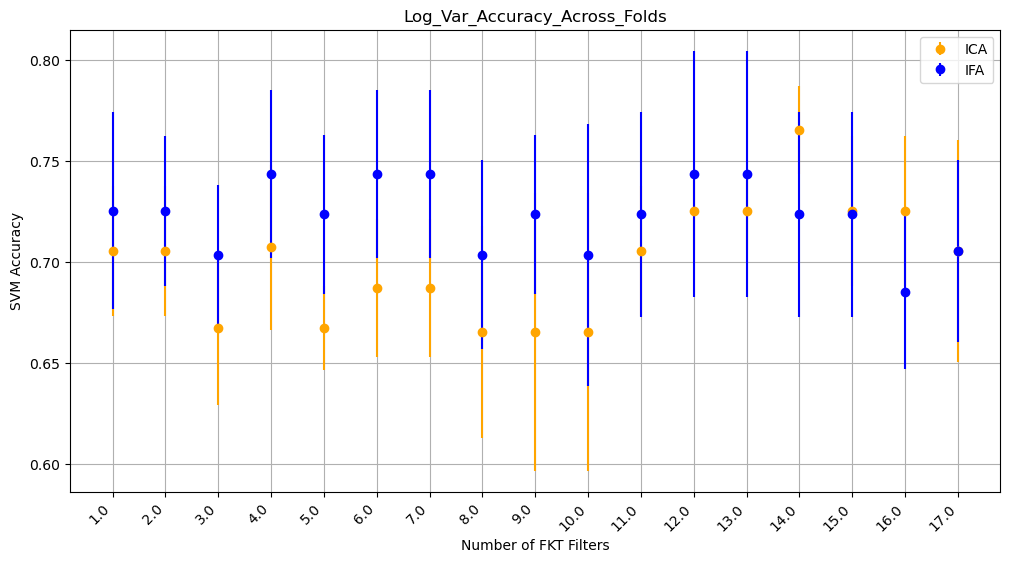

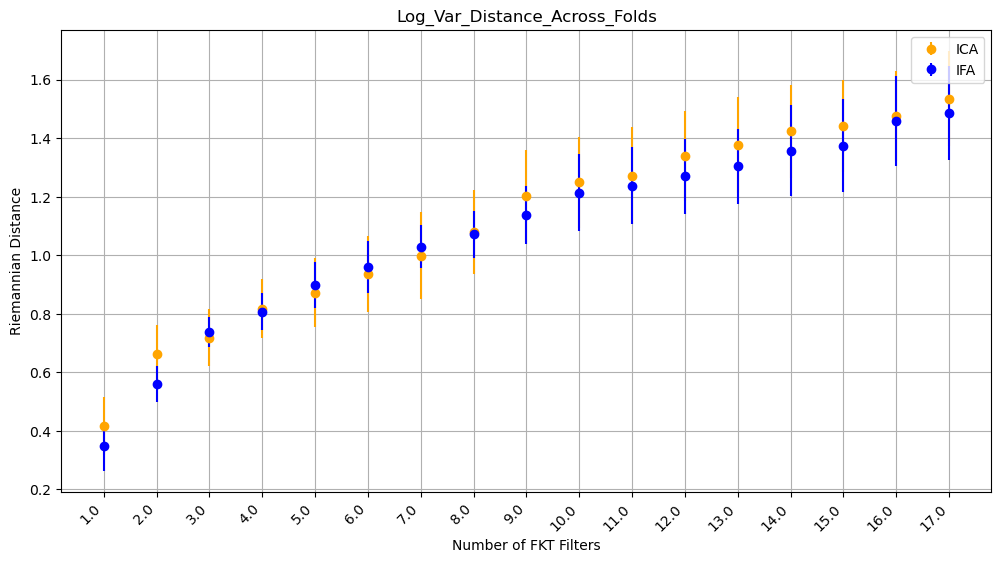

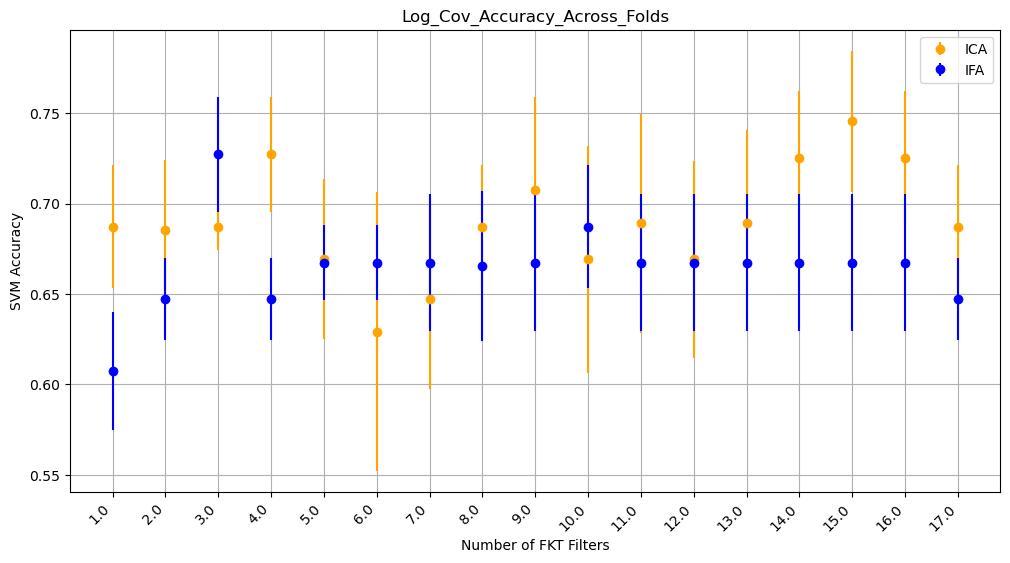

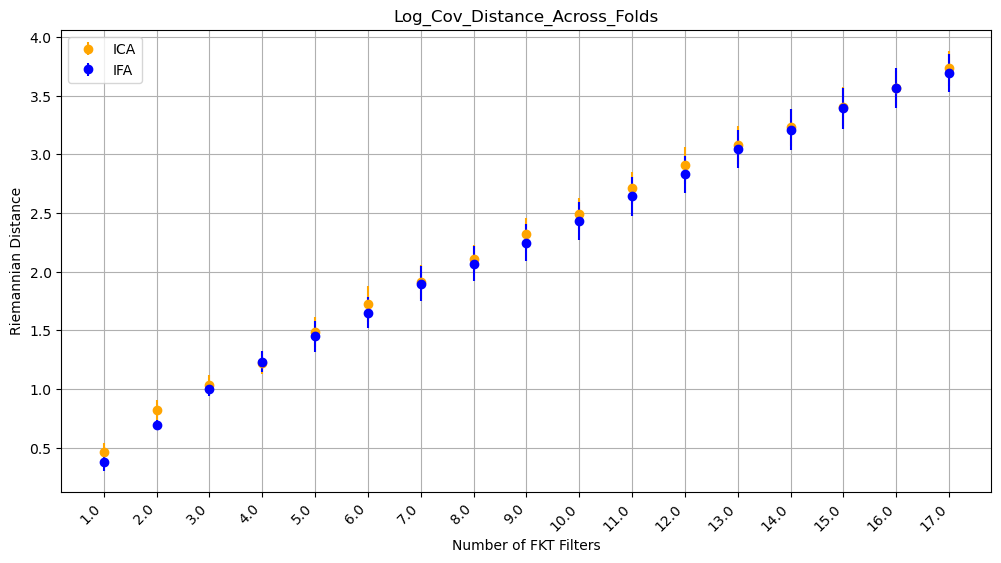

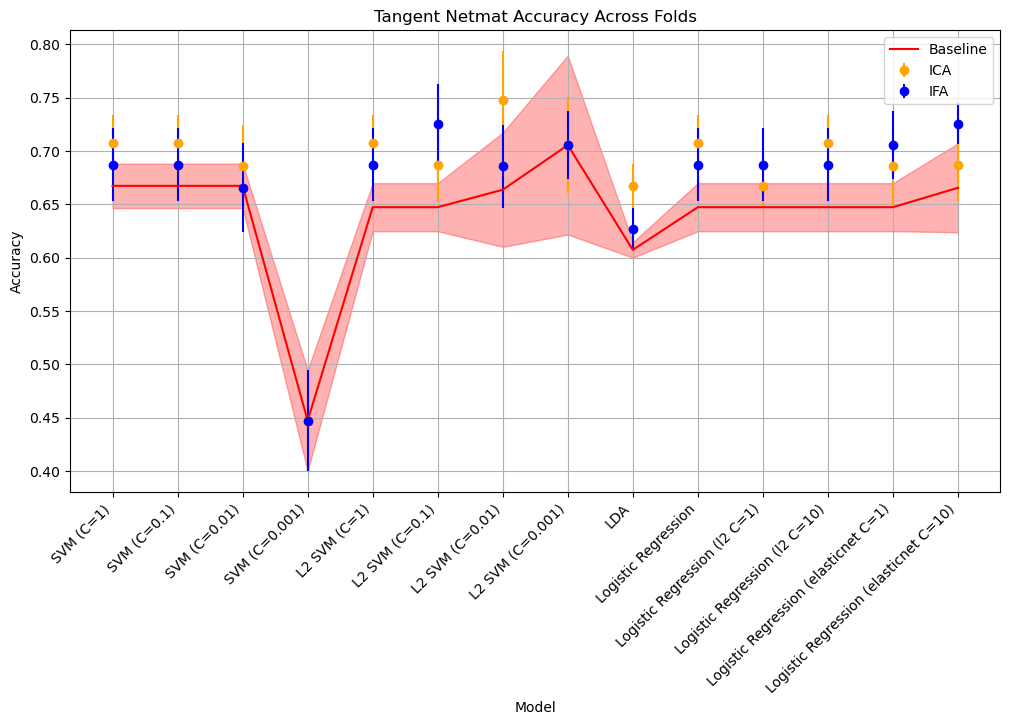

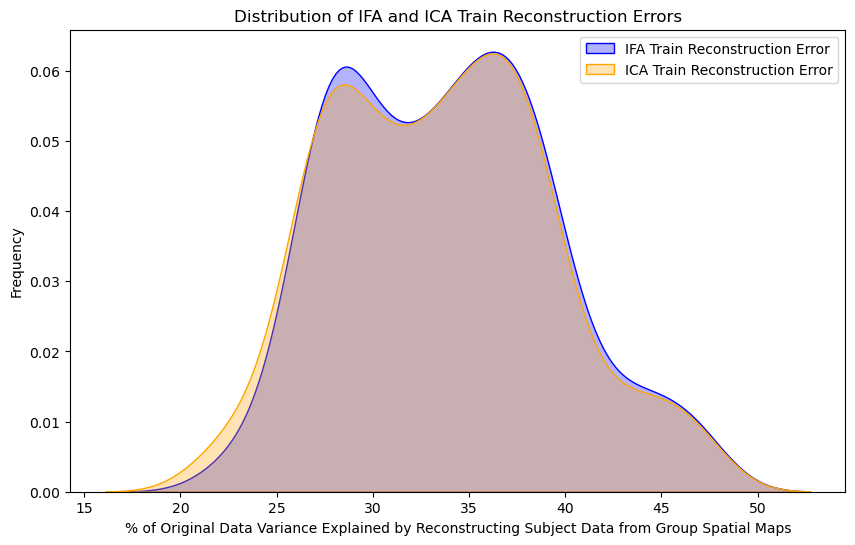

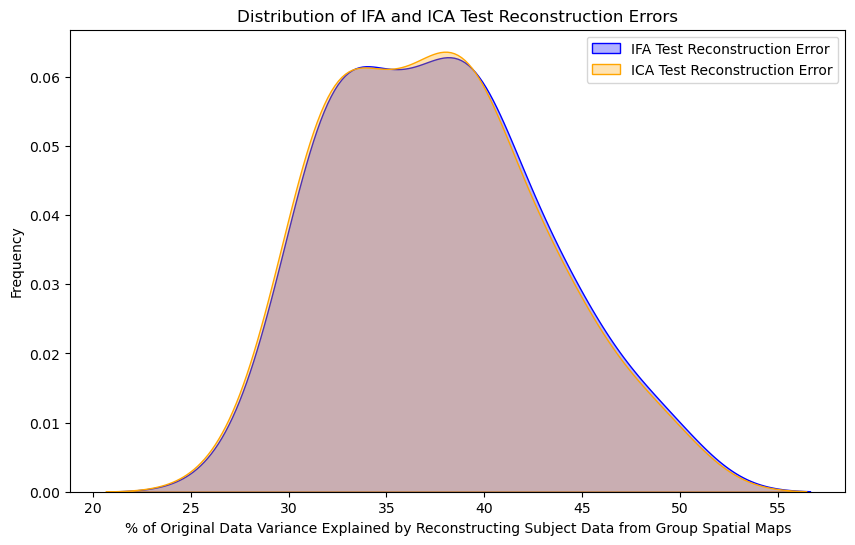

In [11]:
all_results_output_dir_normalized = output_folder / "Results_Normalized"
all_results_output_dir_normalized.mkdir(parents=True, exist_ok=True)


plot_model_comparison(IFA_results_summary_norm["IFA_var_results"][0][:,0],IFA_results_summary_norm["IFA_var_results"][0][:,2],IFA_results_summary_norm["IFA_var_results"][1][:,2],ICA_results_summary_norm["ICA_var_results"][0][:,2],ICA_results_summary_norm["ICA_var_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Var_Accuracy_Across_Folds",output_dir=all_results_output_dir_normalized)
plot_model_comparison(IFA_results_summary_norm["IFA_var_results"][0][:,0],IFA_results_summary_norm["IFA_var_results"][0][:,1],IFA_results_summary_norm["IFA_var_results"][1][:,1],ICA_results_summary_norm["ICA_var_results"][0][:,1],ICA_results_summary_norm["ICA_var_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Var_Distance_Across_Folds",output_dir=all_results_output_dir_normalized)

plot_model_comparison(IFA_results_summary_norm["IFA_cov_results"][0][:,0],IFA_results_summary_norm["IFA_cov_results"][0][:,2],IFA_results_summary_norm["IFA_cov_results"][1][:,2],ICA_results_summary_norm["ICA_cov_results"][0][:,2],ICA_results_summary_norm["ICA_cov_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Cov_Accuracy_Across_Folds",output_dir=all_results_output_dir_normalized)
plot_model_comparison(IFA_results_summary_norm["IFA_cov_results"][0][:,0],IFA_results_summary_norm["IFA_cov_results"][0][:,1],IFA_results_summary_norm["IFA_cov_results"][1][:,1],ICA_results_summary_norm["ICA_cov_results"][0][:,1],ICA_results_summary_norm["ICA_cov_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Cov_Distance_Across_Folds",output_dir=all_results_output_dir_normalized)

plot_model_comparison(IFA_results_summary_norm["IFA_Class_Result"][0],IFA_results_summary_norm["IFA_Class_Result"][1],IFA_results_summary_norm["IFA_Class_Result"][2],ICA_results_summary_norm["ICA_Class_Result"][1],ICA_results_summary_norm["ICA_Class_Result"][2],xlabel="Model", ylabel="Accuracy", title="Tangent Netmat Accuracy Across Folds",output_dir=all_results_output_dir_normalized, baseline=baseline)

reconstruction_plot(IFA_results_summary_norm["IFA_recon"][0], ICA_results_summary_norm["ICA_recon"][0],label="Train",output_dir=all_results_output_dir_normalized)
reconstruction_plot(IFA_results_summary_norm["IFA_recon"][1], ICA_results_summary_norm["ICA_recon"][1],label="Test",output_dir=all_results_output_dir_normalized)

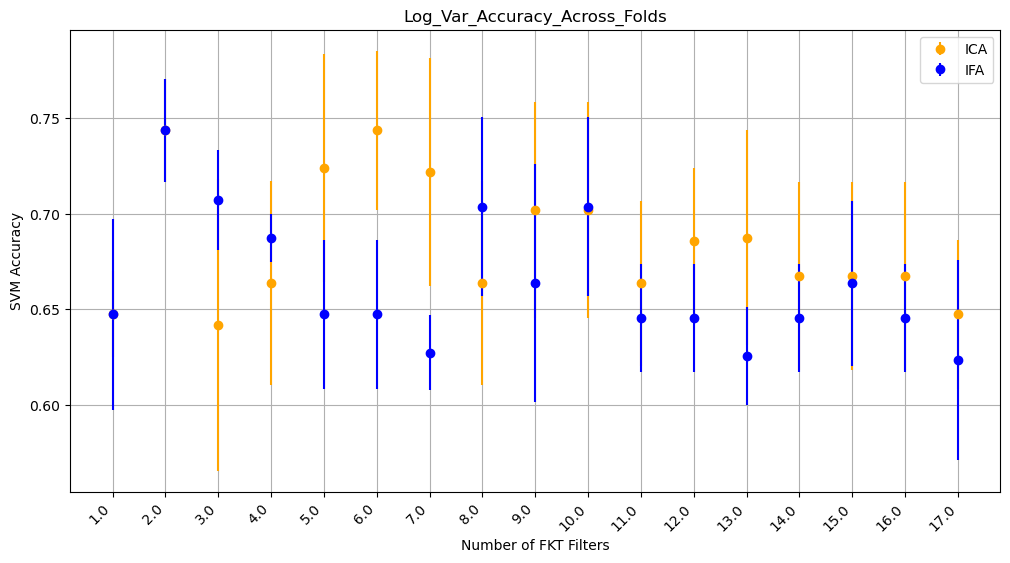

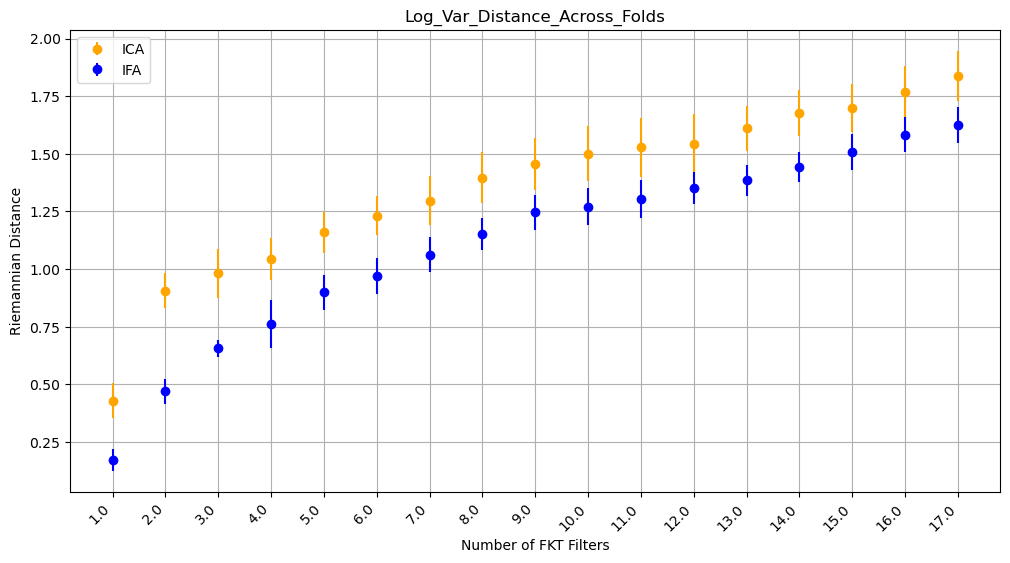

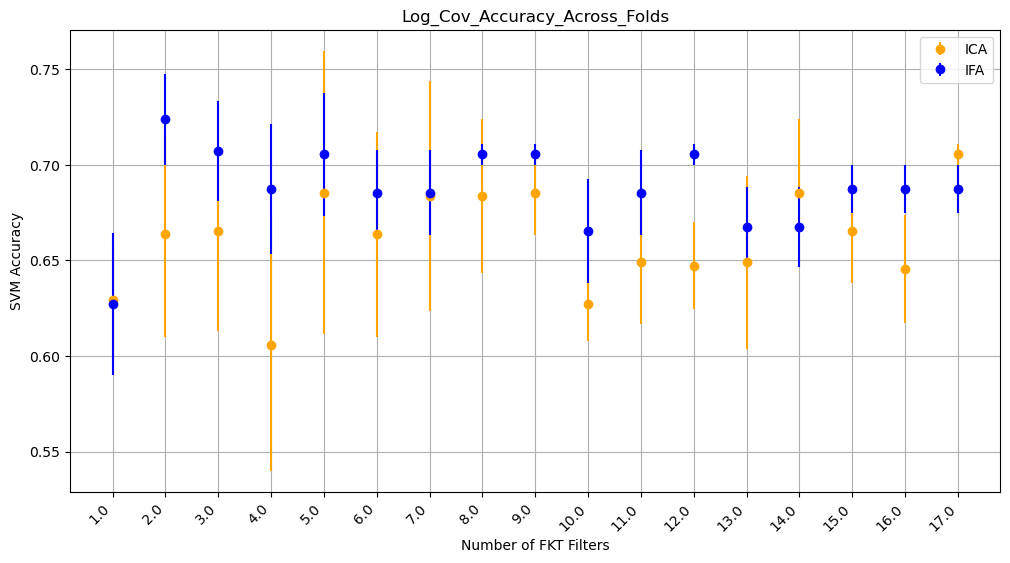

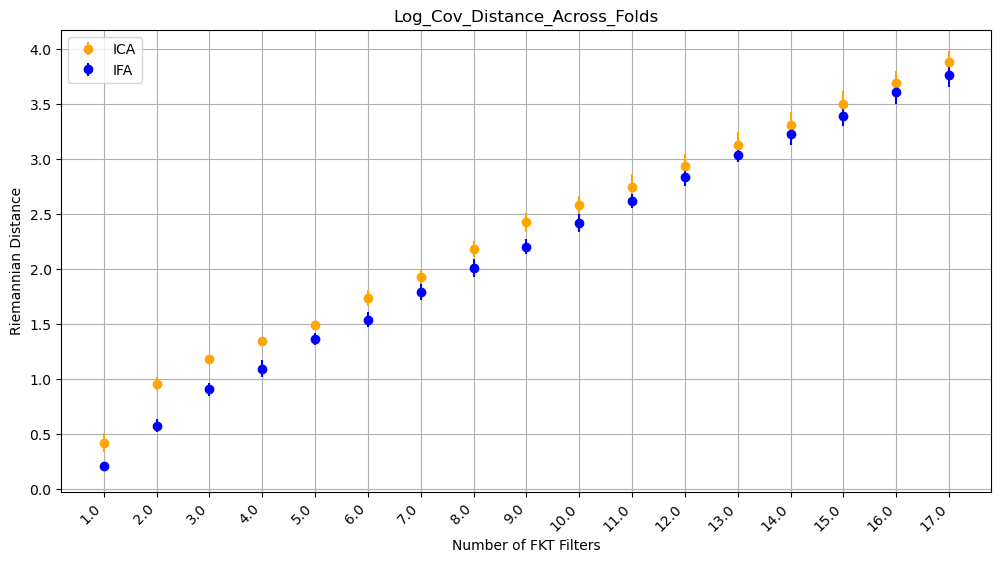

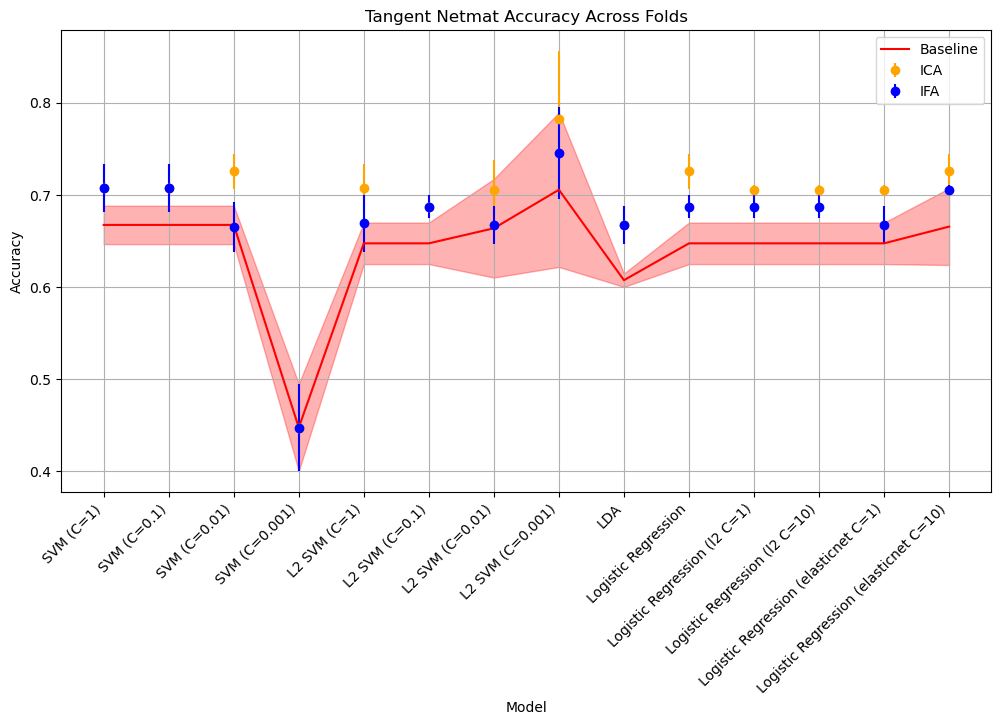

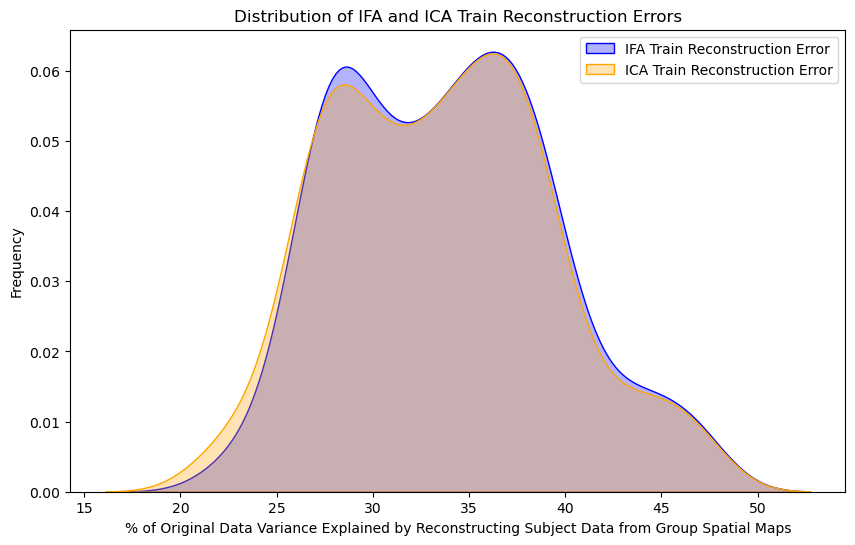

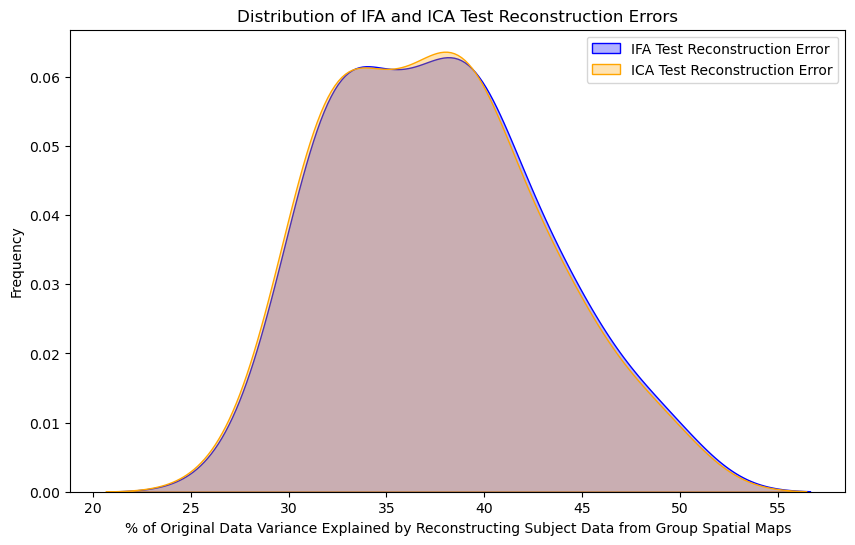

In [12]:
all_results_output_dir_demean = output_folder / "Results_Demeaned"
all_results_output_dir_demean.mkdir(parents=True, exist_ok=True)


plot_model_comparison(IFA_results_summary_demean["IFA_var_results"][0][:,0],IFA_results_summary_demean["IFA_var_results"][0][:,2],IFA_results_summary_demean["IFA_var_results"][1][:,2],ICA_results_summary_demean["ICA_var_results"][0][:,2],ICA_results_summary_demean["ICA_var_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Var_Accuracy_Across_Folds",output_dir=all_results_output_dir_demean)
plot_model_comparison(IFA_results_summary_demean["IFA_var_results"][0][:,0],IFA_results_summary_demean["IFA_var_results"][0][:,1],IFA_results_summary_demean["IFA_var_results"][1][:,1],ICA_results_summary_demean["ICA_var_results"][0][:,1],ICA_results_summary_demean["ICA_var_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Var_Distance_Across_Folds",output_dir=all_results_output_dir_demean)

plot_model_comparison(IFA_results_summary_demean["IFA_cov_results"][0][:,0],IFA_results_summary_demean["IFA_cov_results"][0][:,2],IFA_results_summary_demean["IFA_cov_results"][1][:,2],ICA_results_summary_demean["ICA_cov_results"][0][:,2],ICA_results_summary_demean["ICA_cov_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Cov_Accuracy_Across_Folds",output_dir=all_results_output_dir_demean)
plot_model_comparison(IFA_results_summary_demean["IFA_cov_results"][0][:,0],IFA_results_summary_demean["IFA_cov_results"][0][:,1],IFA_results_summary_demean["IFA_cov_results"][1][:,1],ICA_results_summary_demean["ICA_cov_results"][0][:,1],ICA_results_summary_demean["ICA_cov_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Cov_Distance_Across_Folds",output_dir=all_results_output_dir_demean)

plot_model_comparison(IFA_results_summary_demean["IFA_Class_Result"][0],IFA_results_summary_demean["IFA_Class_Result"][1],IFA_results_summary_demean["IFA_Class_Result"][2],ICA_results_summary_demean["ICA_Class_Result"][1],ICA_results_summary_demean["ICA_Class_Result"][2],xlabel="Model", ylabel="Accuracy", title="Tangent Netmat Accuracy Across Folds",output_dir=all_results_output_dir_demean, baseline=baseline)

reconstruction_plot(IFA_results_summary_demean["IFA_recon"][0], ICA_results_summary_demean["ICA_recon"][0],label="Train",output_dir=all_results_output_dir_demean)
reconstruction_plot(IFA_results_summary_demean["IFA_recon"][1], ICA_results_summary_demean["ICA_recon"][1],label="Test",output_dir=all_results_output_dir_demean)

### Ignore

In [ ]:
import matplotlib.pyplot as plt

# Function to plot time series for parcellated data
def plot_time_series(data, title="Time Series"):
    plt.figure(figsize=(12, 6))
    for parcel_idx, parcel_series in enumerate(data):  # Each row corresponds to a parcel
        plt.plot(parcel_series, label=f"Parcel {parcel_idx+1}" if parcel_idx < 5 else "", alpha=0.6)
    plt.title(title)
    plt.xlabel("Time Points")
    plt.ylabel("Signal Intensity")
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1, fontsize='small', frameon=False)
    plt.grid(True)
    plt.show()

plot_time_series(loaded_df["parcellated_data"][1])

In [ ]:
from nilearn.plotting import plot_roi, plot_stat_map, view_img
import nibabel as nib
from nilearn import image
from nilearn.input_data import NiftiLabelsMasker

# Display the parcellated image over the brain
atlas_path = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
atlas_img = nib.load(atlas_path)
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
masker.fit()
unmask = masker.inverse_transform(loaded_df["parcellated_data"][0])
plot_stat_map(image.index_img(unmask, 0))


In [ ]:
from nilearn.plotting import view_img
view_img(image.index_img(unmask, 0), title="Interactive Parcellated Brain")


In [ ]:
from scipy.ndimage import center_of_mass
import nibabel as nib
import numpy as np

# Load atlas image
atlas_path = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()  # Extract the data array

# Get unique region labels (excluding background)
labels = np.unique(atlas_data)
labels = labels[labels > 0]  # Exclude background (assumed to be 0)

# Compute region centroids (coordinates in voxel space)
coords = [
    center_of_mass(atlas_data == label) for label in labels
]

# Convert voxel coordinates to world coordinates using atlas affine
coords_world = nib.affines.apply_affine(atlas_img.affine, coords)

# Print results
print("Region Coordinates (World Space):", coords_world)


In [ ]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(
    kind="precision",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([loaded_df["parcellated_data"][0]])[0]

# Display the correlation matrix
import numpy as np

from nilearn import plotting

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(
    correlation_matrix, labels=labels, colorbar=True, vmax=0.8, vmin=-0.8
)

In [ ]:
# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(
    correlation_matrix, coords_world, edge_threshold="99.9%", colorbar=True
)

plotting.show()

In [ ]:
view = plotting.view_connectome(
    correlation_matrix, coords_world, edge_threshold="99.9%"
)

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [ ]:
from nilearn.plotting import plot_roi
import nibabel as nib
import numpy as np

# Load the atlas
atlas_path = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Create a binary mask for the region where atlas == 0
zero_mask = (atlas_data == 0).astype(int)
zero_mask_img = nib.Nifti1Image(zero_mask, affine=atlas_img.affine)

# Highlight the 0-labeled region on the brain
plot_roi(zero_mask_img, title="Region Where Atlas = 0", display_mode="ortho", draw_cross=False)


In [ ]:
check = "SUI009"
print(sum(df[check].dropna()))
print(len(df[check].dropna()))
print(sum(df[check].dropna())/len(df[check].dropna()))